# Data Access Notebook for AQS
_by Michelle H Wilkerson, Lucas Coletti_

## Purpose of this Notebook

This notebook was developed as part of NSF Grant 2445609 to support accessing and processing AirNow data for middle and high school classroom activities. It's written to be relatively accessible to beginners, but if you have not interacted with computational notebooks or python before you may find navigating this tool difficult. (Check out the Show Your Work project for a gentle introduction to computational notebooks for educators!)

Our project is focused on supporting data analysis and mechanistic reasoning in science education. In other words, we want students to learn how data provides information about _how scientific mechanisms work_, and how understanding scientific mechanisms can help them to _explain and interpret patterns in data_. This builds on a long history of research on complex systems and agent-based modeling, and more closely connects that work to current expansions of data analysis across subjects.

Here, we are focused on Air Quality as a phenomenon. While most students understand that poor Air Quality can impact health, they may not know that there are many different kinds of air pollution, each caused by different processes and chemicals. These are reflected by different patterns over the course of a day or year

This data tool allows users to connect to the Air Quality System API, search for air quality data streams in an area of interest, identify a date range of interest within that area, and then identifies which (if any) of the available data streams recorded observations for _both_ PM2.5 and O3 in that area and time range. These are two key pollutants that impact air quality and that tend to behave very differently over time. These kinds of datasets can serve as a launch to examining what AQ is and what are its underlying mechanistic and compositional complexities.

You are welcome to modify and adapt this script. You may find the AQS API documentation [here](https://aqs.epa.gov/aqsweb/documents/data_api.html) and the `pyaqsapi` documentation [here](https://usepa.github.io/pyaqsapi/) helpful.

# Part I: Connecting with AQS

Before you get started, you will need an AQS API Key. To get one, make a request using the url `https://aqs.epa.gov/data/api/signup?email=myemail@example.com` (replace myemail@example.com with your email). You will recieve a cute sounding API Key via email. Copy it and set EMAIL and API_KEY in the cell block below to your email and key from the service. (You can use the test email and key that are provided, however, the test account has a limited number of uses per day and may not work. Please register for an account if you would like to use the service.) If you need to reset your key, use this same url with the same email address.

In [1]:
!pip install pyaqsapi # python aqs helper

EMAIL = "test@aqs.api" #replace with your registered email
API_KEY = "test" # replace with your API key

  Using cached pyaqsapi-1.0.2-py3-none-any.whl


Ok, pyaqsapi is super friendly and gives us our data as pandas dataframes. Let's take a look at the monitors available by site.

In [2]:
import pyaqsapi as aqs

try:
    aqs.aqs_credentials(username=EMAIL, key=API_KEY)
except Exception as e:
    print(f"Something didn't work: {e}")

Now, let's identify a location and time period that we want to explore. AQS can fetch data within a bounding box. Let's not get crazy - start with a relatively small bounding box (try one degree for an urban area) and get bigger if you need. (Tip: If you click on a location in Google Maps, you'll see the lat and long for that point in the URL.)

# Part II: Identifying O3 and PM monitors

AQS has settings for different collections of parameters that reflect different "classes" of interest. For example, one parameter is SCHOOL AIR TOXICS which highligts 125 pollutants, or HAZARDOUS AIR POLLUTANTS with a total of 407 pollutants (!). Since we're only interested in O3 and PM, let's find a class that has those two and not much else so we're not taxing the system with our queries. AQI POLLUTANTS looks like a good one, it tracks the "big five" pollutants that are most commonly discussed along with a few other well known pollutants: 

In [3]:
aqs.aqs_parameters_by_class("AQI POLLUTANTS")

,code,value_represented
0,42101,Carbon monoxide
1,42401,Sulfur dioxide
2,42602,Nitrogen dioxide (NO2)
3,44201,Ozone
4,81102,PM10 Total 0-10um STP
5,88101,PM2.5 - Local Conditions
6,88502,Acceptable PM2.5 AQI & Speciation Mass


Ok, so note here that O3 is identified by the five-digit code 44201, and PM25 is identified by 88101. That's the info we need to find the right monitors in the dataset.

In [14]:
# EDIT HERE: define a one unit bounding box around your
# target region. Below, I've defined a box that captures a lot
# of the SF Bay.

min_lat = 40
max_lat = 41

min_long = -74.5
max_long = -73.5

# this is unnecessary but sort of luxurious. let's map the box to
# make sure we're capturing what we want.

import folium

bbox = [[min_lat, min_long], [max_lat, max_long]]

# Calculate the center of the box to position the map
map_center = [(bbox[0][0] + bbox[1][0]) / 2, (bbox[0][1] + bbox[1][1]) / 2]

# Create a Folium map object
m = folium.Map(location=map_center, zoom_start=8)

# Add a rectangle for the bounding box to the map
folium.Rectangle(
    bounds=bbox,
    color="#ff0000",        # Red border
    fill=True,
    fill_color="#ff7800",   # Orange fill
    fill_opacity=0.2
).add_to(m)

m

In [16]:
# EDIT HERE: identify a target date when something interesting
# was happening. Below, I define Jun 6 2023, a big wildfire smoke day in NY

from datetime import datetime, timedelta

target_date = "06-06-2023"
target_datetime = datetime.strptime(target_date, "%m-%d-%Y")

target_datetime

bdate = target_datetime
edate = target_datetime + timedelta(days=1)

Let's start by getting all the active Ozone and PM2.5 monitors in the bounding box during this target date.

In [17]:
relevant_monitors = aqs.bybox.monitors(
    parameter= "44201,88101", #44201 identifies ozone
    bdate=bdate, 
    edate=edate,
    minlat=min_lat,
    maxlat=max_lat,
    minlon=min_long,
    maxlon=max_long,
)

# sort by site to find which have both
relevant_monitors.sort_values('site_number') 

,state_code,county_code,site_number,parameter_code,poc,parameter_name,open_date,close_date,concurred_exclusions,dominant_source,...,address,state_name,county_name,city_name,cbsa_code,cbsa_name,csa_code,csa_name,tribal_code,tribe_name
1,34,039,0004,88101,1,PM2.5 - Local Conditions,1999-01-01,None,None,MOBILE,...,NJ Turnpike Interchange 13 Toll Plaza,New Jersey,Union,Elizabeth,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
23,34,039,0004,88101,3,PM2.5 - Local Conditions,2010-01-01,None,None,MOBILE,...,NJ Turnpike Interchange 13 Toll Plaza,New Jersey,Union,Elizabeth,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
15,34,039,0004,88101,2,PM2.5 - Local Conditions,1999-01-01,None,None,MOBILE,...,NJ Turnpike Interchange 13 Toll Plaza,New Jersey,Union,Elizabeth,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
19,34,031,0005,88101,3,PM2.5 - Local Conditions,2022-07-01,None,None,MOBILE,...,"Paterson Board of Health, 176 Broadway",New Jersey,Passaic,Paterson,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
14,34,025,0005,44201,1,Ozone,1989-05-13,None,None,AREA,...,"Edison Science Hall, off of 400 Cedar Avenue",New Jersey,Monmouth,West Long Branch,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
32,34,003,0006,44201,1,Ozone,2007-12-07,None,None,AREA,...,"Overpeck Park, 40 Fort Lee Road",New Jersey,Bergen,Leonia,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
29,34,017,0006,44201,1,Ozone,1983-01-27,None,None,AREA,...,"Veterans Park, Park Road at end of W. 25th St.",New Jersey,Hudson,Bayonne,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
6,34,029,0006,44201,1,Ozone,1985-01-01,None,None,AREA,...,"JPTD Training Center, south of Success Rd., ea...",New Jersey,Ocean,Jackson (Township of),35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
28,34,017,0008,88101,3,PM2.5 - Local Conditions,2022-01-13,None,None,AREA,...,2500 John F. Kennedy Blvd.,New Jersey,Hudson,Union City,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None
2,34,003,0010,88101,3,PM2.5 - Local Conditions,2015-01-01,None,None,MOBILE,...,"Hoyt Ave & Hudson St, south of toll plaza",New Jersey,Bergen,Fort Lee,35620,"New York-Newark-Jersey City, NY-NJ-PA",408,"New York-Newark, NY-NJ-CT-PA",None,None


Ok great. The table above shows a bunch of candidate sites from which you can extract both PM and O3 data. Let's choose one and take two weeks of sample data (that is the highest resolution of measurements available) around our target date.

In [18]:
# Identify the site number to focus on above. You'll need the 
# state_code, county_code, and site_number. I'm going to pick
# from the options above site 0011 with state_code = 34 and
# county_code = 023.	

# get the 2 week interval around the target
bdate = target_datetime - timedelta(weeks=1)
edate = target_datetime + timedelta(weeks=1)

aqdata = aqs.bysite.sampledata(parameter="44201,88101",
                      bdate=bdate,
                      edate=edate,
                      stateFIPS="34",
                      countycode="023",
                      sitenum="0011")

aqdata

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,date_local,...,detection_limit,uncertainty,qualifier,method_type,method,method_code,state,county,date_of_last_change,cbsa_code
0,34,023,0011,44201,1,40.462182,-74.429439,NAD83,Ozone,2023-05-30,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,087,New Jersey,Middlesex,2023-09-25,35620
1,34,023,0011,44201,1,40.462182,-74.429439,NAD83,Ozone,2023-05-30,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,087,New Jersey,Middlesex,2023-09-25,35620
2,34,023,0011,44201,1,40.462182,-74.429439,NAD83,Ozone,2023-05-30,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,087,New Jersey,Middlesex,2023-09-25,35620
3,34,023,0011,44201,1,40.462182,-74.429439,NAD83,Ozone,2023-05-30,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,087,New Jersey,Middlesex,2023-09-25,35620
4,34,023,0011,44201,1,40.462182,-74.429439,NAD83,Ozone,2023-05-30,...,0.005,None,None,FEM,INSTRUMENTAL - ULTRA VIOLET ABSORPTION,087,New Jersey,Middlesex,2023-09-25,35620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,2023-06-13,...,2.000,None,None,FEM,Thermo Scientific 5014i or FH62C14-DHS w/VSCC ...,183,New Jersey,Middlesex,2023-09-27,35620
721,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,2023-06-13,...,2.000,None,None,FEM,Thermo Scientific 5014i or FH62C14-DHS w/VSCC ...,183,New Jersey,Middlesex,2023-09-27,35620
722,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,2023-06-13,...,2.000,None,None,FEM,Thermo Scientific 5014i or FH62C14-DHS w/VSCC ...,183,New Jersey,Middlesex,2023-09-27,35620
723,34,023,0011,88101,3,40.462182,-74.429439,NAD83,PM2.5 - Local Conditions,2023-06-13,...,2.000,None,None,FEM,Thermo Scientific 5014i or FH62C14-DHS w/VSCC ...,183,New Jersey,Middlesex,2023-09-27,35620


In [19]:
aqdata.columns

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'date_local',
       'time_local', 'date_gmt', 'time_gmt', 'sample_measurement',
       'units_of_measure', 'units_of_measure_code', 'sample_duration',
       'sample_duration_code', 'sample_frequency', 'detection_limit',
       'uncertainty', 'qualifier', 'method_type', 'method', 'method_code',
       'state', 'county', 'date_of_last_change', 'cbsa_code'],
      dtype='object')

You'll see that annoyingly, there is a local date and a local time, and a gmt date and a gmt time, but no datetime. Let's add that since otherwise we'll miss useful resoltuion in our data.

In [24]:
import pandas as pd

combined_series = aqdata['date_local'] + ' ' + aqdata['time_local']
aqdata['datetime_local'] = pd.to_datetime(combined_series, format="%Y-%m-%d %H:%M")

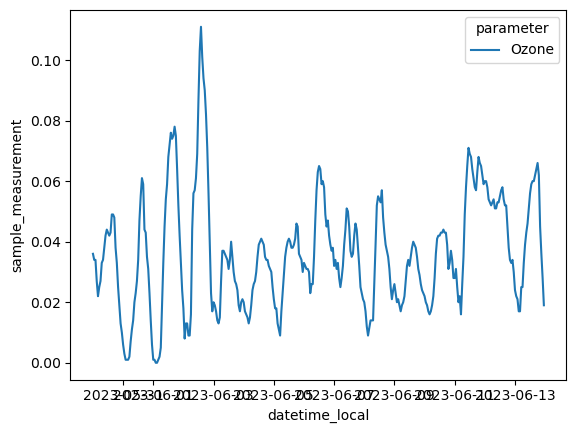

In [25]:
#let's plot
import seaborn as sns

line_plot = sns.lineplot(
    data=aqdata[aqdata['parameter_code'] == '44201'], # dplyr filter far superior ijs
    x='datetime_local',
    y='sample_measurement',
    hue='parameter',
)

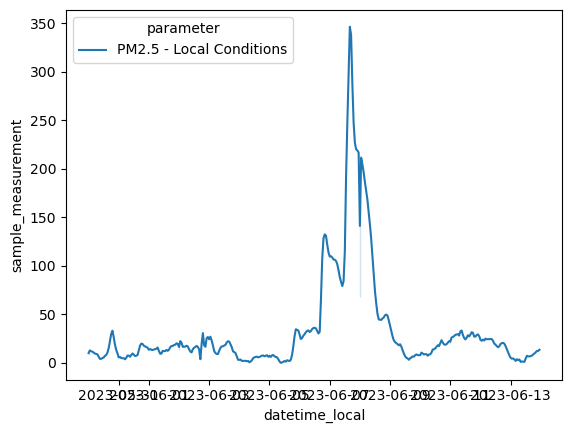

In [26]:
import seaborn as sns

line_plot = sns.lineplot(
    data=aqdata[aqdata['parameter_code'] == '88101'], # dplyr filter far superior ijs
    x='datetime_local',
    y='sample_measurement',
    hue='parameter',
)

In [27]:
aqdata.to_csv("filename.csv")

# Credit

https://aqs.epa.gov/aqsweb/documents/about_aqs_data.html